In [111]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
import pandas as pd

In [112]:
class QuantumCircuit:
    """
    This class provides a simple interface for interaction
    with the quantum circuit
    """

    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)

        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')

        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)

        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds=[{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()

        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)

        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)

        return np.array([expectation])


Expected value for rotation pi 0.51


/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


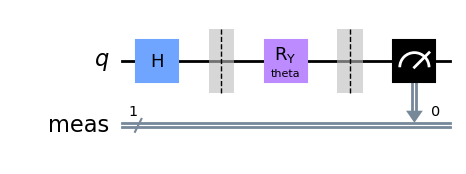

In [113]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw(output='mpl')


In [114]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """

    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result

    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())

        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift

        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left = ctx.quantum_circuit.run(shift_left[i])

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None


class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """

    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)


In [115]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x_train = torch.tensor(np.array(x, dtype='float32'), dtype=torch.float32)
        self.y_train = torch.tensor(np.array(y, dtype='int8'), dtype=torch.int64)

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

In [116]:
df = pd.read_csv('datasets/vlds.csv', index_col=0)
feature_dimension = df.shape[1] - 1

train = df.sample(frac=0.75, random_state=42)
test = df.drop(train.index)

# Separate the features from the labels
train_features = train.copy()
test_features = test.copy()

train_labels = train_features.pop('label')
test_labels = test_features.pop('label')

train_loader = torch.utils.data.DataLoader(MyDataset(train_features, train_labels), batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(MyDataset(test_features, test_labels), batch_size=1, shuffle=True)

In [119]:
class Net(nn.Module):
    def __init__(self, feature_dimension, backend):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(feature_dimension, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(backend, shots=100, shift=np.pi / 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [120]:
model = Net(feature_dimension=feature_dimension, backend=simulator)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    loss_list.append(sum(total_loss) / len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))


/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/var/folders/qt/7kgmbkhs4y1_3klkg31szy8r0000gn/T/ipykernel_9009/3430279302.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.9495
Training [10%]	Loss: -0.9722
Training [15%]	Loss: -0.9761
Training [20%]	Loss: -0.9786
Training [25%]	Loss: -0.9800
Training [30%]	Loss: -0.9806
Training [35%]	Loss: -0.9812
Training [40%]	Loss: -0.9814
Training [45%]	Loss: -0.9814
Training [50%]	Loss: -0.9815
Training [55%]	Loss: -0.9823
Training [60%]	Loss: -0.9822
Training [65%]	Loss: -0.9817
Training [70%]	Loss: -0.9820
Training [75%]	Loss: -0.9822
Training [80%]	Loss: -0.9824
Training [85%]	Loss: -0.9823
Training [90%]	Loss: -0.9822
Training [95%]	Loss: -0.9820
Training [100%]	Loss: -0.9823


Text(0, 0.5, 'Neg Log Likelihood Loss')

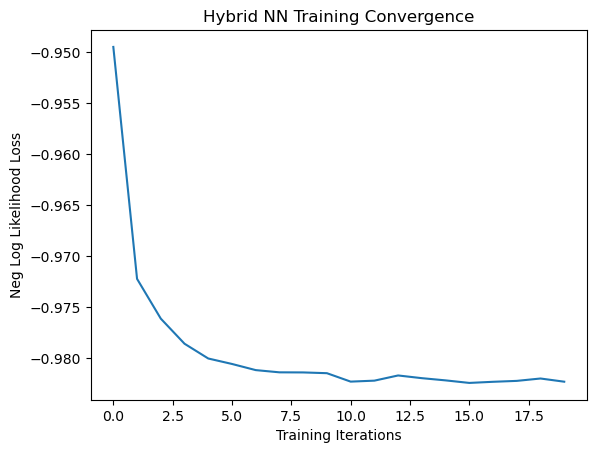

In [121]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')


In [122]:
model.eval()
with torch.no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
    )


/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Performance on test data:
	Loss: -0.9814
	Accuracy: 98.0%
